# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [208]:
# Import relevant libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model

In [209]:
## Load the data into a DataFrame
df = pd.read_csv('../data/Iowa_Liquor_sales_sample_10pct.csv')

In [210]:
#df.drop(['Unnamed: 0', 'Invoice/Item Number', 'Store Name', 'Address', 'Vendor Name', 'Pack'], axis=1, inplace=True)
#df.info()


In [211]:
## Transform the dates column
df["Date"] = pd.to_datetime(df["Date"], format='%m/%d/%Y')

In [212]:
df.head()

,Date,Store Number,City,Zip Code,County Number,County,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,9.0,Bremer,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,82.0,Scott,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,7.0,Black Hawk,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,85.0,Story,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,99.0,Wright,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55


To ensure accuracy, we are importing a list of Iowa zip codes, cities, counties and county numbers.

In [213]:
location_data = pd.read_csv('../data/ia_zip_city_county_sqm.csv')

In [214]:
location_data.head()

,Unnamed: 0,zip,primary_city,county,state,County#,ZCTA5CE10,area-sqm
0,0,50001,ACKWORTH,Warren,IA,91,50001,62796656
1,1,50002,ADAIR,Guthrie,IA,39,50002,279202219
2,2,50003,ADEL,Dallas,IA,25,50003,298086291
3,3,50005,ALBION,Marshall,IA,64,50005,69623573
4,4,50006,ALDEN,Hardin,IA,42,50006,317745150


In [215]:
location_data.columns = ['number', 'Zip Code', 'City', 'County', 'State','County Number', 'repeat', 'Area (sqkm)']

In [216]:
location_data.drop(['number', 'repeat'], axis=1, inplace=True)

In [217]:
location_data['Area (sqkm)'] = location_data['Area (sqkm)'] / 1000000

We will run a check on zip codes before joining the 2 tables

In [218]:
liquor_zips = df['Zip Code'].drop_duplicates().tolist()
ref_zips = location_data['Zip Code'].astype(str).tolist()
z = [x for x in liquor_zips if x not in ref_zips]
print z

['52303', '712-2', '52087', '52084', '52036', '52733', '56201', '50300']


In [219]:
for i in z:
    print df[['Zip Code', 'City', 'County', 'County Number']][df['Zip Code'] == i].drop_duplicates()
    city = df['City'][df['Zip Code'] == i].drop_duplicates().iloc[0].upper()
    print city
    try:
        print location_data[location_data['City']==city].drop_duplicates()
    except:
        print i, 'not in Iowa'
    print

   Zip Code          City County  County Number
78    52303  CEDAR RAPIDS   Linn           57.0
CEDAR RAPIDS
     Zip Code          City County State  County Number  Area (sqkm)
805     52401  CEDAR RAPIDS   Linn    IA             57     3.464505
806     52402  CEDAR RAPIDS   Linn    IA             57    36.420817
807     52403  CEDAR RAPIDS   Linn    IA             57    69.523743
808     52404  CEDAR RAPIDS   Linn    IA             57   142.933490
809     52405  CEDAR RAPIDS   Linn    IA             57    38.493180
810     52411  CEDAR RAPIDS   Linn    IA             57    44.635019

     Zip Code    City    County  County Number
114     712-2  DUNLAP  Harrison           43.0
8186    712-2  DUNLAP       NaN            NaN
DUNLAP
     Zip Code    City    County State  County Number  Area (sqkm)
570     51529  DUNLAP  Harrison    IA             43   333.953737

    Zip Code        City    County  County Number
267    52087  MANCHESTER  Delaware           28.0
MANCHESTER
     Zip Code  

Based on the above, we get a vague idea of what the zips are supposed to be

In [220]:
corrected_zips = ['52403','51529', '52057','52804','0','52732','52601','50309']
for i in range(len(z)):
    df.ix[df['Zip Code']==z[i], 'Zip Code']=corrected_zips[i]

In [221]:
# Run the test again
liquor_zips = df['Zip Code'].drop_duplicates().tolist()
ref_zips = location_data['Zip Code'].astype(str).tolist()
z = [x for x in liquor_zips if x not in ref_zips]
print z

['0']


In [222]:
df['Zip Code'] = df['Zip Code'].astype(int)

Now we merge our location data to our liquor sales

In [223]:
df2 = df.copy()
df2.drop(['County Number', 'City', 'County'], axis=1, inplace=True)
df2 = df2.merge(location_data, how='left', on='Zip Code')
df2.drop(['State'], axis=1, inplace=True)

In [224]:
df2.head()

,Date,Store Number,Zip Code,Category,Category Name,Vendor Number,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons),City,County,County Number,Area (sqkm)
0,2015-11-04,3717,50674,1051100.0,APRICOT BRANDIES,55,54436,Mr. Boston Apricot Brandy,750,$4.50,$6.75,12,$81.00,9.0,2.38,SUMNER,Bremer,9.0,408.690075
1,2016-03-02,2614,52807,1011100.0,BLENDED WHISKIES,395,27605,Tin Cup,750,$13.75,$20.63,2,$41.26,1.5,0.40,DAVENPORT,Scott,82.0,76.469440
2,2016-02-11,2106,50613,1011200.0,STRAIGHT BOURBON WHISKIES,65,19067,Jim Beam,1000,$12.59,$18.89,24,$453.36,24.0,6.34,CEDAR FALLS,Black Hawk,7.0,329.972902
3,2016-02-03,2501,50010,1071100.0,AMERICAN COCKTAILS,395,59154,1800 Ultimate Margarita,1750,$9.50,$14.25,6,$85.50,10.5,2.77,AMES,Story,85.0,155.294118
4,2015-08-18,3654,50421,1031080.0,VODKA 80 PROOF,297,35918,Five O'clock Vodka,1750,$7.20,$10.80,12,$129.60,21.0,5.55,BELMOND,Wright,99.0,232.911303


In [225]:
df2.dtypes

Date                     datetime64[ns]
Store Number                      int64
Zip Code                          int64
Category                        float64
Category Name                    object
Vendor Number                     int64
Item Number                       int64
Item Description                 object
Bottle Volume (ml)                int64
State Bottle Cost                object
State Bottle Retail              object
Bottles Sold                      int64
Sale (Dollars)                   object
Volume Sold (Liters)            float64
Volume Sold (Gallons)           float64
City                             object
County                           object
County Number                   float64
Area (sqkm)                     float64
dtype: object

In [226]:
# Write a function that cross references related columns and fills the data in where it's missing
def fill_missing(related_cols, column, dataframe):
    related_cols.remove(column)
    reference = dataframe[related_cols][dataframe[column].isnull()].drop_duplicates()
    for j in range(len(related_cols)):
        col_1 = reference[related_cols[j]]
        for i in col_1:
            try:
                x = dataframe[column][(dataframe[related_cols[j]]==i) & (dataframe[column].notnull())].drop_duplicates()
                if len(x) < 2:
                    #print 'Missing: {}, Reference: {}, Ref_value: {}, filler: {}'.\
                    #format(column, related_cols[j], i, x.iloc[0])
                    value = x.iloc[0]
                    dataframe.ix[(dataframe[related_cols[j]]==i) & (dataframe[column].isnull()), column] = value
            except:
                pass

In [227]:
fill_missing(['Category', 'Category Name'], 'Category Name', df2)
fill_missing(['Category', 'Category Name'], 'Category', df2)

fill_missing(['Item Number', 'Item Description'], 'Item Description', df2)
fill_missing(['Item Number', 'Item Description'], 'Item Number', df2)

In [228]:
# Convert all dollar columns to floats
df2['State Bottle Cost'] = df2['State Bottle Cost'].map(lambda x: x.strip('$')).astype(float)
df2['State Bottle Retail'] = df2['State Bottle Retail'].map(lambda x: x.strip('$')).astype(float)
df2['Sale (Dollars)'] = df2['Sale (Dollars)'].map(lambda x: x.strip('$')).astype(float)

In [229]:
# Extract Month and Year
df2['Month'] = df2['Date'].map(lambda x: x.month)
df2['Year'] = df2['Date'].map(lambda x: x.year)

For the purposes of our market research, we will only be considering full years' data.  
Any year which is not a full year will be dropped.  
We would also like to aggregate sales by zip code and dollar per litre by zip code.  
We also want to know how many stores there are per zip code.

In [230]:
df3 = df2.copy()[df2['Year']==2015]

# Aggregate sales and volume by zip code
agg_sales = pd.pivot_table(df3, index=['Zip Code'], \
               values=['Bottles Sold', 'Volume Sold (Liters)', 'Sale (Dollars)'],\
                     aggfunc=[np.median, sum]).reset_index()
df2 = df2.merge(agg_sales, how='left',on='Zip Code')

# Get number of stores
df3_gb = df2[['Zip Code','Store Number']].drop_duplicates()
df3_gb = df3_gb.rename(columns={'Store Number': 'StoreCount'})
df3_gb = df3_gb.groupby(['Zip Code']).count().reset_index()
df2 = df2.merge(df3_gb, how='left', on='Zip Code')

In [231]:

df2.columns.values

array(['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',
       'Vendor Number', 'Item Number', 'Item Description',
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',
       'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)',
       'Volume Sold (Gallons)', 'City', 'County', 'County Number',
       'Area (sqkm)', 'Month', 'Year', ('median', 'Bottles Sold'),
       ('median', 'Sale (Dollars)'), ('median', 'Volume Sold (Liters)'),
       ('sum', 'Bottles Sold'), ('sum', 'Sale (Dollars)'),
       ('sum', 'Volume Sold (Liters)'), 'StoreCount'], dtype=object)

In [232]:
# Rename the columns
df2.columns = ['Date', 'Store Number', 'Zip Code', 'Category', 'Category Name',\
       'Vendor Number', 'Item Number', 'Item Description',\
       'Bottle Volume (ml)', 'State Bottle Cost', 'State Bottle Retail',\
       'Bottles Sold', 'Sale (Dollars)', 'Volume Sold (Liters)',\
       'Volume Sold (Gallons)', 'City', 'County', 'County Number', 'Area (sqkm)','Month',\
       'Year', 'median bottles sold', 'median sales',\
       'median volume sold', 'total bottles sold', 'total sales', 'total volume sold', 'Store Count', 'Dollar per litre', 'Stores per sqkm']

ValueError: Length mismatch: Expected axis has 28 elements, new values have 30 elements

In [ ]:
# Adding a column for dollar per litre
df2['Dollar per litre'] = df2['total sales']/df2['total volume sold']

In [ ]:
# Adding a column for stores per sqm
df2['Stores per sqkm'] = df2['Store Count']/(df2['Area (sqkm)'])


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

In [233]:
# We're just interested in the following columns
col_required = ['Zip Code', 'median bottles sold', 'median sales', 'median volume sold',\
                'total bottles sold', 'total sales', 'total volume sold', 'Store Count',\
                'Dollar per litre', 'Area (sqkm)', 'Stores per sqkm']
full_df = df2
sales_df = full_df.copy()
sales_df = sales_df[sales_df['Year']==2015]
sales_df = sales_df[col_required]

KeyError: "['median bottles sold' 'median sales' 'median volume sold'\n 'total bottles sold' 'total sales' 'total volume sold' 'Store Count'\n 'Dollar per litre' 'Stores per sqkm'] not in index"

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

Our hypothesis is that the demographics of an area would affect the liquor sales there.  
Ideally, we would have wanted to combine our liquor sales data with the demographics data of the corresponding year.  
We were unable to do that and have combined it with the demographics data that we were able to find.  
- This may compromise our model and we should seek to improve it if possible

In [234]:
# Read in our demographics data
demo_df = pd.read_csv('../data/IowaZIPdemos.csv')

In [235]:
# Remove any rows with null values
# Convert zips to integers for easy comparison
demo_df.dropna(inplace=True)
demo_df['Area'] = demo_df['Area'].astype(int)

In [236]:
demo_cols = demo_df.columns.values.tolist()

object_cols = [i for i in demo_cols if demo_df[i].dtype == 'O']

In [237]:
# Define a function to remove symbols and convert numbers to floats
def rem_symbols(x):
    for i in [',', '%', '$', '-']:
        x = x.replace(i, '')
    try:
        return float(x)
    except:
        print x
    
for i in object_cols:
    demo_df[i] = demo_df[i].map(rem_symbols)

In [238]:
model_df = sales_df.merge(demo_df, how='left', left_on='Zip Code', right_on='Area')

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

KeyError: "['total sales'] not in index"

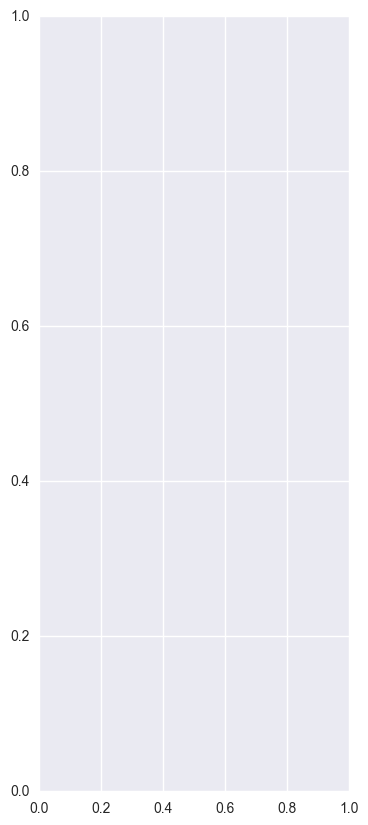

In [239]:
fig, ax = plt.subplots(figsize=(4,10));
sns.heatmap(model_df.corr()[['total sales']].iloc[12:]);

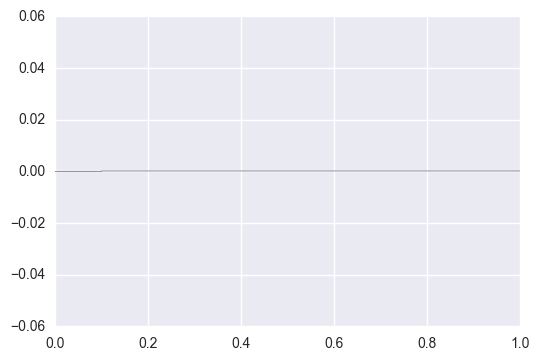

In [203]:
model_df['total sales'].hist();

ValueError: zero-size array to reduction operation minimum which has no identity

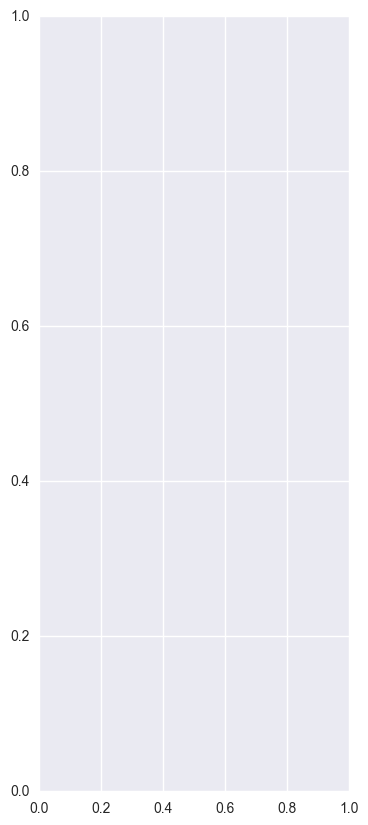

In [169]:
fig, ax = plt.subplots(figsize=(4,10));
sns.heatmap(model_df.corr()[['Dollar per litre']].iloc[12:]);

In [ ]:
model_df['Dollar per litre'].hist();

In [170]:
# Remove outliers in sales that are 3 std away from the median
sales_median = model_df['total sales'].median()
sales_std = model_df['total sales'].std()
model_df = model_df[abs(model_df['total sales'] - sales_median) <= 3*sales_std]

In [171]:
# Remove outliers in dollar per litre that are 3 std away from the median
dollar_median = model_df['Dollar per litre'].median()
dollar_std = model_df['Dollar per litre'].std()
model_df = model_df[abs(model_df['Dollar per litre'] - dollar_median) <= 3*dollar_std]

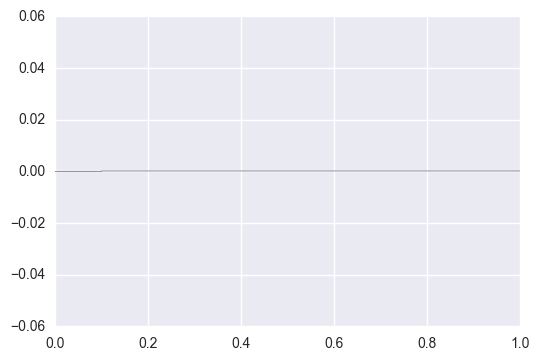

In [172]:
model_df['total sales'].hist();

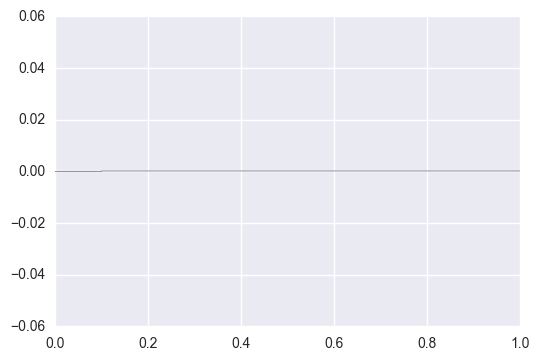

In [173]:
model_df['Dollar per litre'].hist();

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [174]:
features = model_df.columns.values.tolist()
print features

['Zip Code', 'median bottles sold', 'median sales', 'median volume sold', 'total bottles sold', 'total sales', 'total volume sold', 'Store Count', 'Dollar per litre', 'Area (sqkm)', 'Stores per sqkm', 'Area', 'Total Pop', 'Median HH Inc', 'Per Capita Inc', 'White', 'Afr Amer', 'Native Amer', 'Asian Amer', 'Pac Islander', 'Other', 'Bi- Multi-Racial', 'Hispanic or Latino', 'Med Age', '<5 years', '5-17 yrs', '18-20 yrs', '21-24 yrs', '25-34 yrs', '35-44 yrs', '45-54 yrs', '55-59 yrs', '60-64 yrs', '65-74 yrs', '78-84 yrs', '85+ yrs', '% P16+ in labor force', 'Total # Homes Owned', 'Med. Home Value', 'Tot Housing units', 'Owner occupied housing units', 'Renter occupied housing units', 'households', 'Family households', 'Married-couple family households', 'Single mother households', 'Nonfamily households', 'Single Occupancy', 'Avg HH Size', 'Avg Family Size', 'Pop Below Poverty Level', '% P25+ HS Grad', '% P25-54 BA+']


In [175]:
drop_features = ['Zip Code', 'median bottles sold', 'median sales',\
                 'median volume sold', 'total bottles sold', 'total sales',\
                 'total volume sold', 'Store Count', 'Dollar per litre', 'Area (sqkm)', 'Stores per sqkm', 'Area']
for i in drop_features:
    features.remove(i)


In [176]:
model_df.dropna(inplace=True)
X = model_df[features]

In [177]:
y_sales = model_df['total sales']
ridge = linear_model.RidgeCV(cv=5)
model_sales = ridge.fit(X,y_sales)
print 'r-squared: {}'.format(model_sales.score(X,y_sales))
print 'alpha applied: {}'.format(model_sales.alpha_)

feature_imp = pd.DataFrame([features, model_sales.coef_.tolist()], index=['feature', 'coef']).T
feature_imp['coef'] = feature_imp['coef'].astype(float)
feature_imp = feature_imp.sort_values(by='coef', ascending=False)

predicted_sales = model_sales.predict(X)
plt.scatter(predicted_sales, y_sales);
plt.plot([min(y_sales), max(y_sales)], [min(y_sales), max(y_sales)], '-');
plt.title('Predicted and actual sales');
plt.xlabel('Predicted sales');
plt.ylabel('Actual sales');

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: 0.

In [178]:
y_dollar = model_df['Dollar per litre']
ridge2 = linear_model.RidgeCV(cv=5)
model_dollar = ridge2.fit(X,y_dollar)
print 'r-squared: {}'.format(model_dollar.score(X,y_dollar))
print 'alpha applied: {}'.format(model_dollar.alpha_)

feature_imp_d = pd.DataFrame([features, model_dollar.coef_.tolist()], index=['feature', 'coef']).T
feature_imp_d['coef'] = feature_imp_d['coef'].astype(float)
feature_imp_d = feature_imp_d.sort_values(by='coef', ascending=False)

predicted_dollar = model_dollar.predict(X)
plt.scatter(predicted_dollar, y_dollar);
plt.plot([min(y_dollar), max(y_dollar)], [min(y_dollar), max(y_dollar)], '-');
plt.title('Predicted and actual dollar per litre');
plt.xlabel('Predicted');
plt.ylabel('Actual');

ValueError: Cannot have number of splits n_splits=5 greater than the number of samples: 0.

In [179]:
predict_df = location_data.copy()
predict_df = predict_df.merge(demo_df, left_on='Zip Code', right_on='Area')

In [180]:
predict_df.head()

,Zip Code,City,County,State,County Number,Area (sqkm),Area,Total Pop,Median HH Inc,Per Capita Inc,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,50001,ACKWORTH,Warren,IA,91,62.796656,50001,615.0,43611.0,17803.0,...,174.0,158.0,12.0,42.0,34.0,2.85,3.21,711.0,88.8,9.7
1,50002,ADAIR,Guthrie,IA,39,279.202219,50002,1339.0,32500.0,20580.0,...,370.0,333.0,30.0,205.0,185.0,2.25,2.86,1232.0,87.6,11.2
2,50003,ADEL,Dallas,IA,25,298.086291,50003,5835.0,47649.0,22429.0,...,1615.0,1390.0,162.0,619.0,529.0,2.58,3.08,5816.0,91.0,24.0
3,50005,ALBION,Marshall,IA,64,69.623573,50005,851.0,41786.0,15267.0,...,251.0,208.0,28.0,69.0,56.0,2.66,2.98,917.0,80.8,12.7
4,50006,ALDEN,Hardin,IA,42,317.745150,50006,1959.0,36494.0,16957.0,...,547.0,477.0,43.0,220.0,194.0,2.55,3.09,1939.0,88.9,14.8


In [181]:
X_predict = predict_df[features]
all_sales = model_sales.predict(X_predict)
all_dollar_per_litre = model_dollar.predict(X_predict)

NameError: name 'model_sales' is not defined

In [182]:
all_sales = pd.DataFrame(all_sales, columns=['predicted total sales'])
all_dollar_per_litre = pd.DataFrame(all_dollar_per_litre, columns=['predicted dollar/litre'])

NameError: name 'all_sales' is not defined

In [183]:
predict_df['predicted total sales'] = all_sales['predicted total sales']
predict_df['predicted dollar/litre'] = all_dollar_per_litre['predicted dollar/litre']

NameError: name 'all_sales' is not defined

In [184]:
predict_df.head()

,Zip Code,City,County,State,County Number,Area (sqkm),Area,Total Pop,Median HH Inc,Per Capita Inc,...,Family households,Married-couple family households,Single mother households,Nonfamily households,Single Occupancy,Avg HH Size,Avg Family Size,Pop Below Poverty Level,% P25+ HS Grad,% P25-54 BA+
0,50001,ACKWORTH,Warren,IA,91,62.796656,50001,615.0,43611.0,17803.0,...,174.0,158.0,12.0,42.0,34.0,2.85,3.21,711.0,88.8,9.7
1,50002,ADAIR,Guthrie,IA,39,279.202219,50002,1339.0,32500.0,20580.0,...,370.0,333.0,30.0,205.0,185.0,2.25,2.86,1232.0,87.6,11.2
2,50003,ADEL,Dallas,IA,25,298.086291,50003,5835.0,47649.0,22429.0,...,1615.0,1390.0,162.0,619.0,529.0,2.58,3.08,5816.0,91.0,24.0
3,50005,ALBION,Marshall,IA,64,69.623573,50005,851.0,41786.0,15267.0,...,251.0,208.0,28.0,69.0,56.0,2.66,2.98,917.0,80.8,12.7
4,50006,ALDEN,Hardin,IA,42,317.745150,50006,1959.0,36494.0,16957.0,...,547.0,477.0,43.0,220.0,194.0,2.55,3.09,1939.0,88.9,14.8


In [185]:
present_columns = ['Zip Code', 'predicted total sales', 'predicted dollar/litre']

In [240]:
present_df = predict_df[present_columns]

In [241]:
present_df = present_df.merge(df2[['Zip Code', 'Store Count', 'Area (sqkm)', 'Stores per sqkm']],\
                              how='left', on='Zip Code').drop_duplicates()

In [245]:
present_df.head()

,Zip Code,predicted total sales,predicted dollar/litre,Store Count,Area (sqkm),Stores per sqkm
0,50001,31403.433188,12.069858,NaN,NaN,NaN
1,50002,-17928.066139,12.874650,2.0,279.202219,0.007163
44,50003,100097.353165,13.188819,3.0,298.086291,0.010064
362,50005,-42036.887281,12.181796,NaN,NaN,NaN
363,50006,4836.162018,12.794107,2.0,317.745150,0.006294


In [246]:
present_df.to_csv('../data/present_pred.csv')

In [247]:
top_10 = present_df.sort_values(by='predicted total sales', ascending=False).head(10)

In [248]:
top_10

,Zip Code,predicted total sales,predicted dollar/litre,Store Count,Area (sqkm),Stores per sqkm
185116,52240,878576.482818,15.818783,20.0,415.571318,0.048127
211962,52402,813570.002695,13.818488,30.0,36.420817,0.823705
2600,50010,713467.642736,14.601469,21.0,155.294118,0.135227
45989,50266,599692.135562,17.268292,16.0,43.060835,0.371567
154613,51501,549954.844844,14.883510,26.0,68.663347,0.378659
168403,52001,530856.247100,14.631493,18.0,75.057763,0.239815
103139,50613,501084.128869,14.226150,16.0,329.972902,0.048489
52467,50311,494089.592045,15.048624,7.0,6.511832,1.074966
76254,50322,490394.697904,16.298098,19.0,27.938267,0.680071
268241,52807,488299.198552,15.599518,9.0,76.469440,0.117694


## Record your findings

Be sure to write out anything observations from your exploratory analysis.

In [187]:
from sklearn import linear_model


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.